In [1]:
from data_extraction import *
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from CWT import MRA
from tqdm import tqdm
import tensorflow as tf

In [42]:
class ExtractionTransformer( BaseEstimator, TransformerMixin):
        def __init__(self,t0,t1,filter_channels):
            print('\n initialize extraction')
            self.t0 = t0
            self.t1 = t1
            self.filter_channels = filter_channels
            pass
        
        def fit(self, X_=None, y_=None):
            print("Importing data...\n")
            data = EEGProcess().extraction(s1=(2,22),s2=(20,37),s3=(38,60),t0_s=self.t0, t1_s=self.t1,states=[1,2,3])
            X = data.drop(columns = ['Control','X5'])
            y = data['Control']
            X_copy = X.copy()
            for key in X.columns:
                X_copy[key] = X[key].apply(lambda x: len(x))
            est_len = int((self.t1- self.t0)*200)
            X.drop(X_copy[X_copy['O1']!=est_len].index, inplace=True)
            y.drop(X_copy[X_copy['O1']!=est_len].index, inplace=True)
            print('Converting to matrix... \n')
            if len(self.filter_channels)>=1:
                df_mat = np.zeros([X.values.shape[0],len(self.filter_channels),est_len])
                X = X[self.filter_channels]
                for i in tqdm(range(X.values.shape[0])):
                    for j in range(len(self.filter_channels)):
                        for k in range(est_len):
                            df_mat[i][j][k] =  X.values[i][j][k]
            else:
                df_mat = np.zeros([X.values.shape[0],X.values.shape[1],est_len])
                for i in tqdm(range(X.values.shape[0])):
                    for j in range(X.values.shape[1]):
                        for k in range(est_len):
                            df_mat[i][j][k] =  X.values[i][j][k]
            print(f'Resulting X matrix shape {df_mat.shape}\n')
            self.X = df_mat
            self.y = y.values
            return self

        def transform(self, X=None,y=None):
            print('Extract Transform invoqued ')
            return self.X,self.y


In [117]:
x_dummy =1
y_dummy=1
dummy_x = 1
dummy_y = 1
t0 =-0.5
t1=1.0
chan = ['C3','C4','T3','T4','Cz','Fz']
n_c=6
f_int=1
stage = ExtractionTransformer(t0=t0,t1=t1,filter_channels=[])



 initialize extraction


In [44]:
def plot_specto(num_rows, num_columns, width, height, data,t0,t1,fi,ff,cm):
    """Plot a montage of 20 spectograms"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 22.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    k = 0
    channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
       'A1', 'A2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'X5']
    for i in range(rows_data):
        for j in range(columns_data):
            img = np.transpose(np.rot90(abs(data[i][j])**2))
            axarr[i, j].imshow(img,extent=[t0,t1,ff,fi],aspect='auto', cmap=cm)
            axarr[i,j].set_title(f'Channel {channels[k]}')
            k+=1
            if not(i in range(rows_data)[-1:]):
                axarr[i, j].xaxis.set_visible(False)
    plt.subplots_adjust(wspace=.05, hspace=.2, left=0, right=1, bottom=0, top=1)
    plt.show()

In [90]:
X_train = np.load('Pre-Dat/Fp1-F3-P4-O2-A1-T3/X_train.npy')
X_test = np.load('Pre-Dat/Fp1-F3-P4-O2-A1-T3/X_test.npy')
y_train = np.load('Pre-Dat/Fp1-F3-P4-O2-A1-T3/y_train.npy')
y_test = np.load('Pre-Dat/Fp1-F3-P4-O2-A1-T3/y_test.npy')

In [118]:
X_pipe, y_pipe= stage.fit_transform(dummy_x,dummy_y)

Importing data...



  0%|                                                                               | 16/13606 [00:00<03:10, 71.48it/s]

Converting to matrix... 



100%|████████████████████████████████████████████████████████████████████████████| 13606/13606 [03:12<00:00, 70.63it/s]


Resulting X matrix shape (13606, 21, 300)

Extract Transform invoqued 


In [119]:
X_pipe.shape

(13606, 21, 300)

In [120]:
X_pipe_2 = np.moveaxis(X_pipe,1,2)

In [121]:
X_pipe_2.shape

(13606, 300, 21)

In [122]:
X_state1 = X_pipe[y_pipe==1][:2]
X_state2 = X_pipe[y_pipe==2][:2]
X_state3 = X_pipe[y_pipe==3][:2]

Text(0, 0.5, 'Canales')

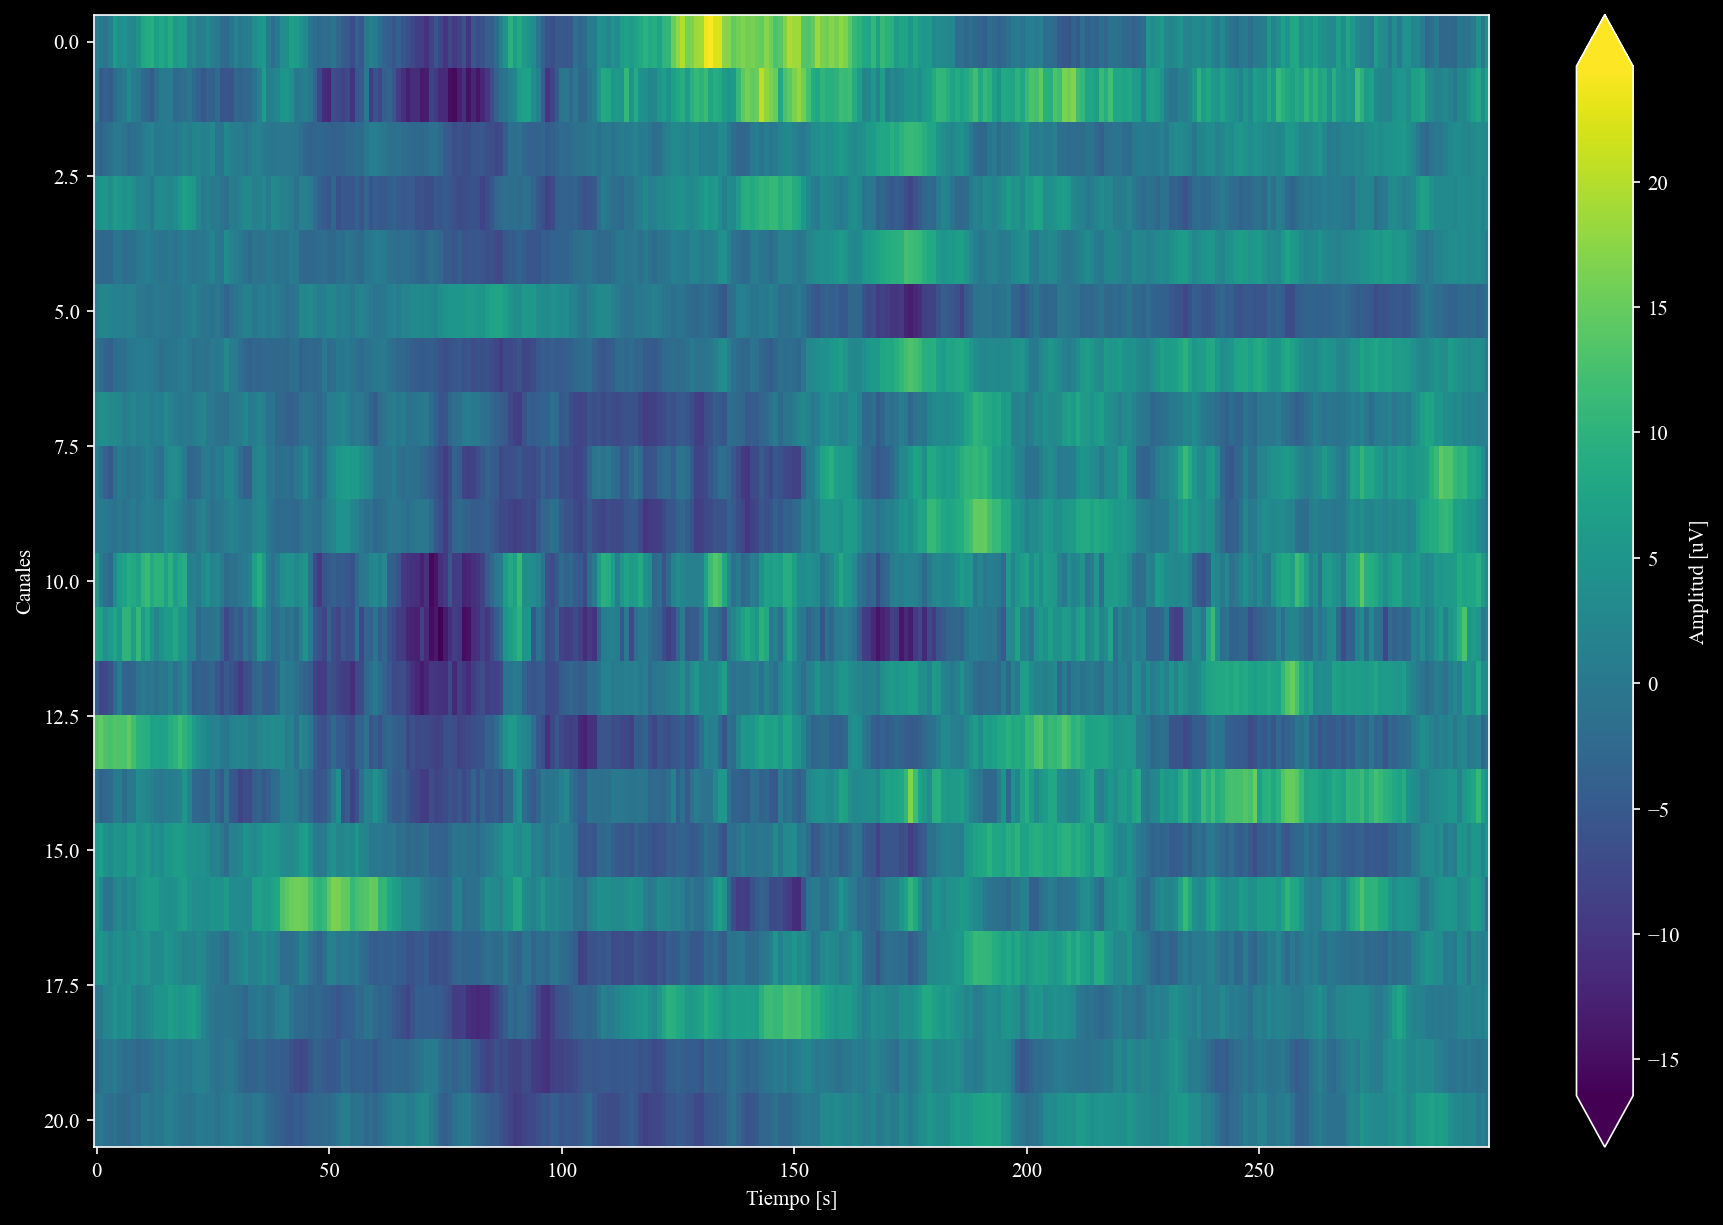

In [123]:
plt.rcParams['figure.figsize'] = (15, 10)
plt.imshow(X_state1[0], aspect='auto')
plt.colorbar(extend='both',label=r'Amplitud [uV]')
plt.xlabel('Tiempo [s]')
plt.ylabel('Canales')

In [104]:
from mycolorpy import colorlist as mcp
import matplotlib as mpl  
mpl.rc('font',family='Times New Roman')
plt.style.use('dark_background')
def signals(X,state,cm):
    colormap = mcp.gen_color(cmap=cm,n=(X.shape[0]))
    for c in range(X.shape[0]):
        t = np.arange(t0,t1,1/200)
        plt.rcParams['figure.figsize'] = (27, 3)
        plt.rcParams['figure.dpi'] = (150)
        plt.plot(t,X[c],c=colormap[c],label=f'{chan[c]}')
        plt.title(f'Señales {state}')
        plt.xlabel('Tiempo [s]')
        plt.ylabel('Voltaje [uV]')
        plt.legend()
    plt.show()

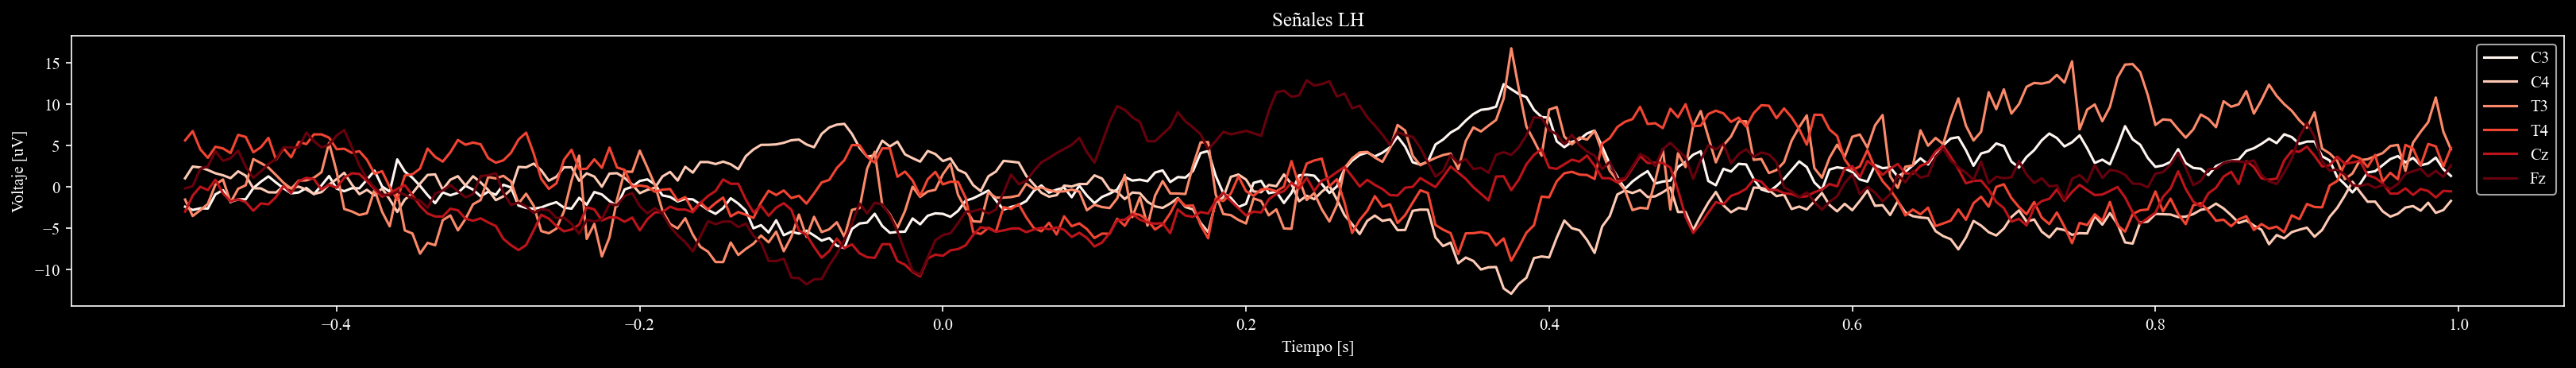

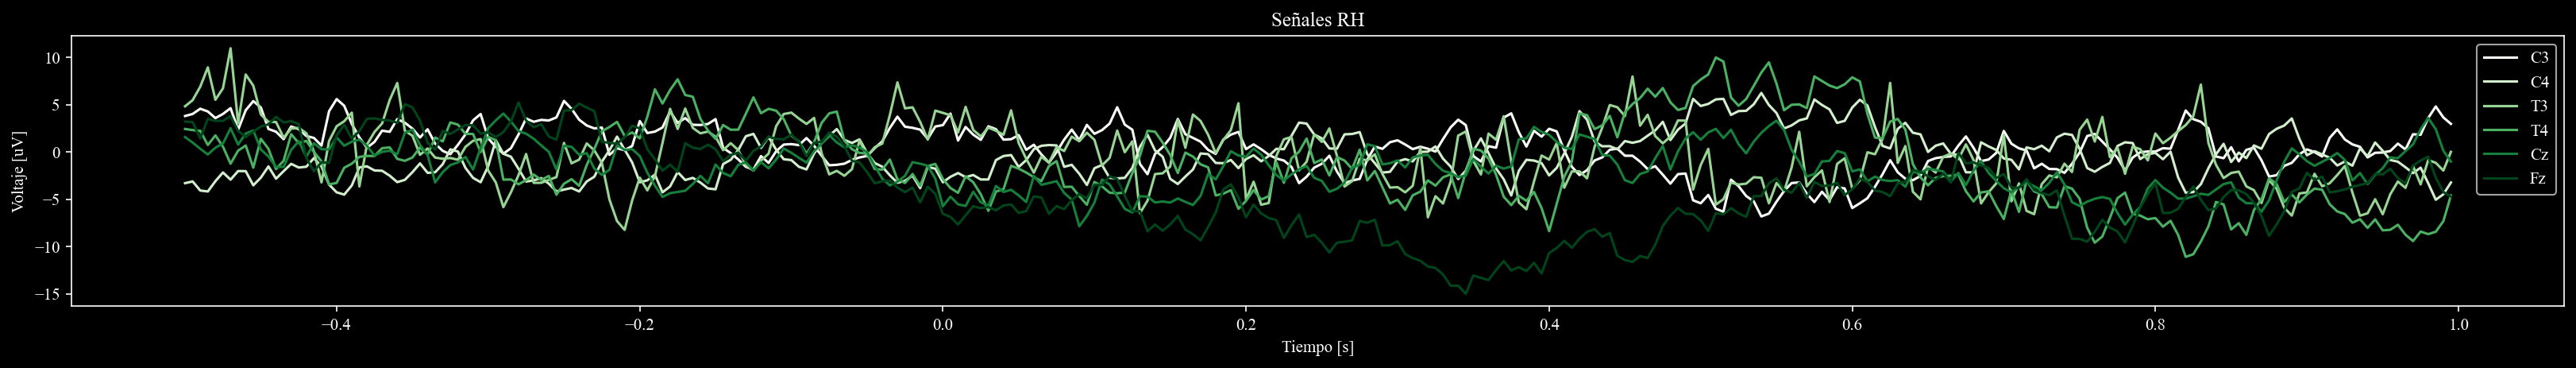

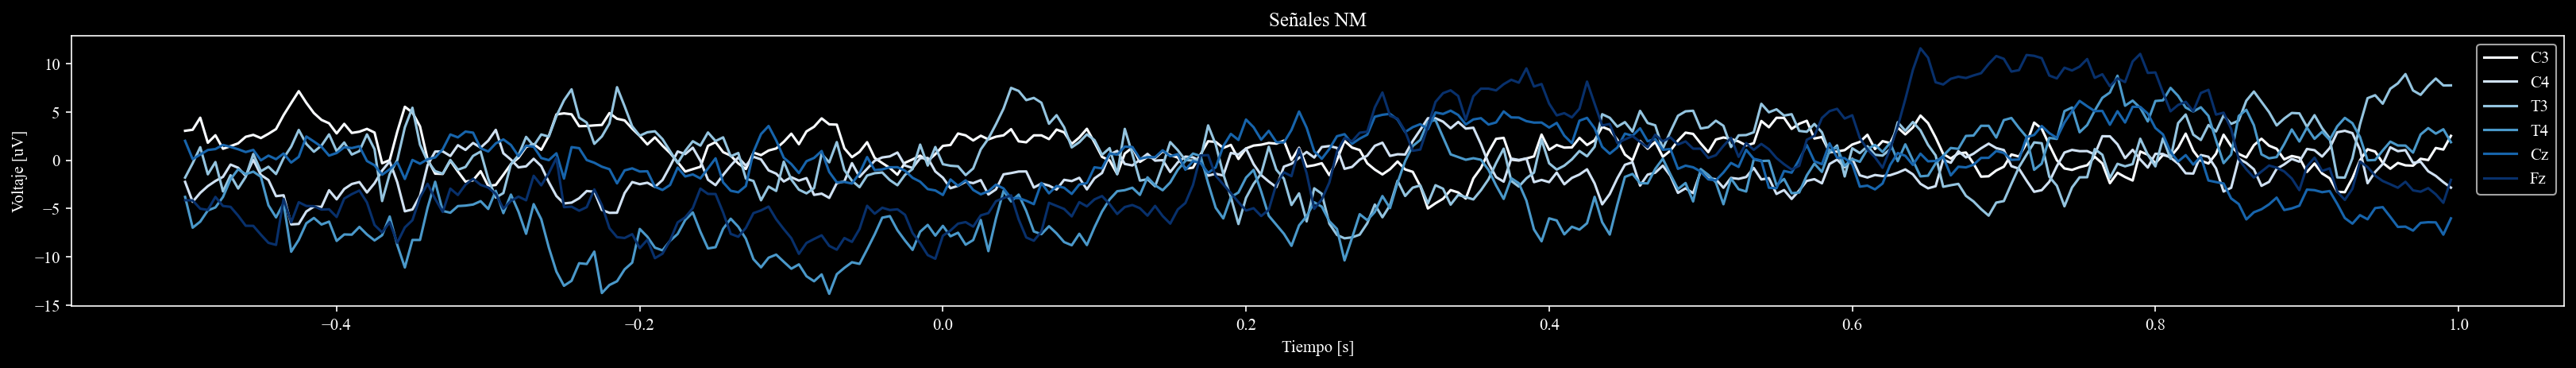

In [105]:
signals(X_state1[0],'LH','Reds')
signals(X_state2[0],'RH','Greens')
signals(X_state3[0],'NM','Blues')

In [62]:
X_state1.shape

(2, 6, 300)

In [25]:
def CWT(X_,f_int,n_c,fi=1,ff=20):
    k = int((ff-fi)/f_int)
    n = X_.shape[2]
    X_fit = np.zeros([X_.shape[0],X_.shape[1],k,n],dtype=np.float16)
    n_i = n_c-2
    n_f = n_c+2
    for i in tqdm(range(X_.shape[0])):
        for j in range(X_.shape[1]):
            channel_signal = X_[i,j]
            spect = MRA(channel_signal, fi,ff,f_int, n_i,n_f)
            for k_ in range(k):
                for n_ in range(n):
                    X_fit[i,j,k_,n_] = spect[k_,n_]
    return X_fit

In [26]:
def normalizer(X):
    n_sam = X.shape[0]
    n_chan = X.shape[1]
    X_ = abs(X.astype('float32'))**2
    for i in tqdm(range(n_sam)):
        for j in range(n_chan):
            X_[i,j] = (X_[i,j] - X_[i,j].mean())/X_[i,j].std()
    return X_
            

In [27]:
fi=1
ff=20
nc = 3
f_int=0.2
X_state1_cwt = CWT(X_state1,n_c=nc,f_int=f_int,fi=fi,ff=ff)
X_state2_cwt = CWT(X_state2,n_c=nc,f_int=f_int,fi=fi,ff=ff)
X_state3_cwt = CWT(X_state3,n_c=nc,f_int=f_int,fi=fi,ff=ff)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  7.27it/s]


In [28]:
np.moveaxis(X_state1_cwt,1,3).shape

(2, 95, 300, 5)

In [29]:
X_state1_cwt = normalizer(X_state1_cwt)
X_state2_cwt = normalizer(X_state2_cwt)
X_state3_cwt = normalizer(X_state3_cwt)

100%|███████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 998.76it/s]


In [30]:
X_state1_cwt[0,0].shape

(95, 300)

In [31]:
X_state1_cwt = np.moveaxis(X_state1_cwt,1,3)
X_state2_cwt = np.moveaxis(X_state2_cwt,1,3)
X_state3_cwt = np.moveaxis(X_state3_cwt,1,3)

image_state1 = np.expand_dims(X_state1_cwt[0],axis=3)
image_state2 = np.expand_dims(X_state2_cwt[0],axis=3)
image_state3 = np.expand_dims(X_state3_cwt[0],axis=3)

In [32]:
image_state1.shape

(95, 300, 5, 1)

In [55]:
np.reshape(image_state1,(2,2,95,300)).shape

ValueError: cannot reshape array of size 142500 into shape (2,2,95,300)

In [54]:
size = 95
print('State1')
plot_specto(2, 2, size, 300, image_state1,t0=t0,t1=t1,ff=ff,fi=fi,cm='turbo')

State1


ValueError: cannot reshape array of size 142500 into shape (2,2,95,300)

State2


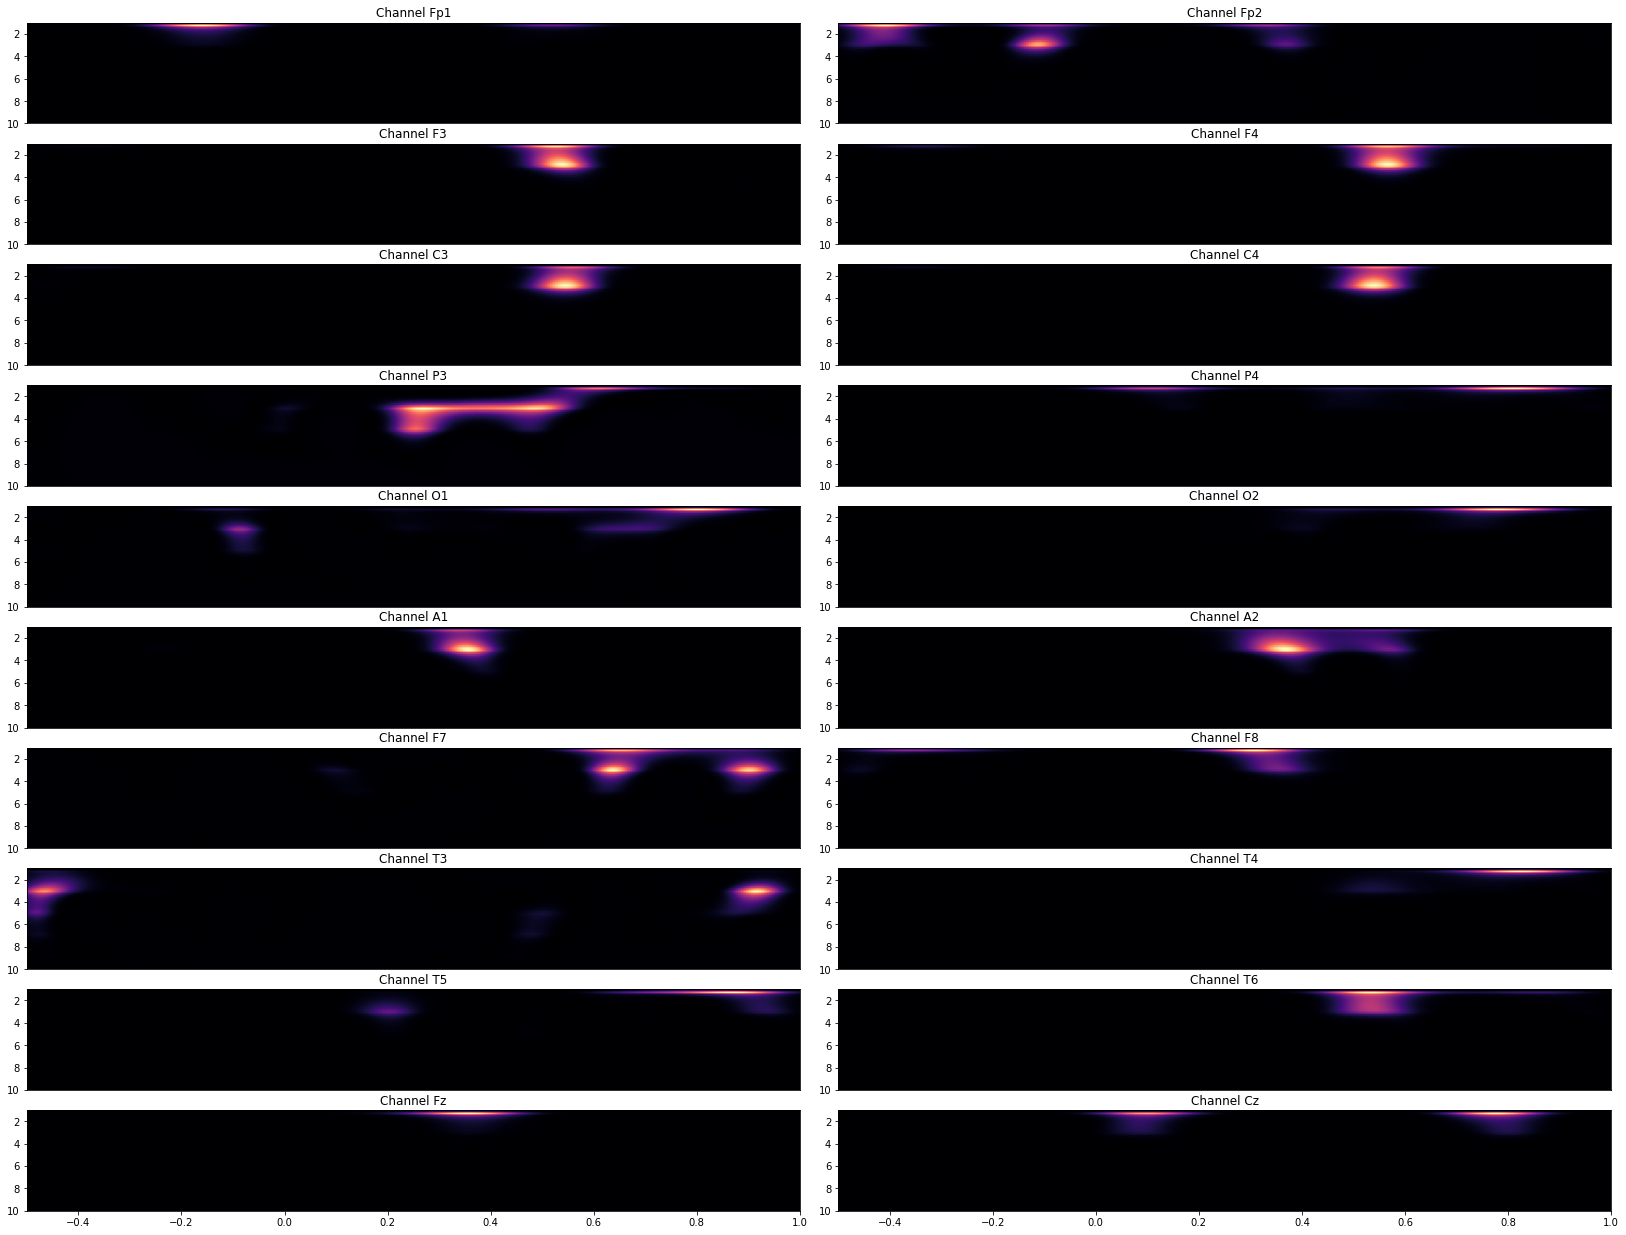

In [44]:
print('State2')
plot_specto(10, 2, size, 300, image_state2[:,:,:20],t0=t0,t1=t1,ff=ff,fi=fi,cm='magma')

State3


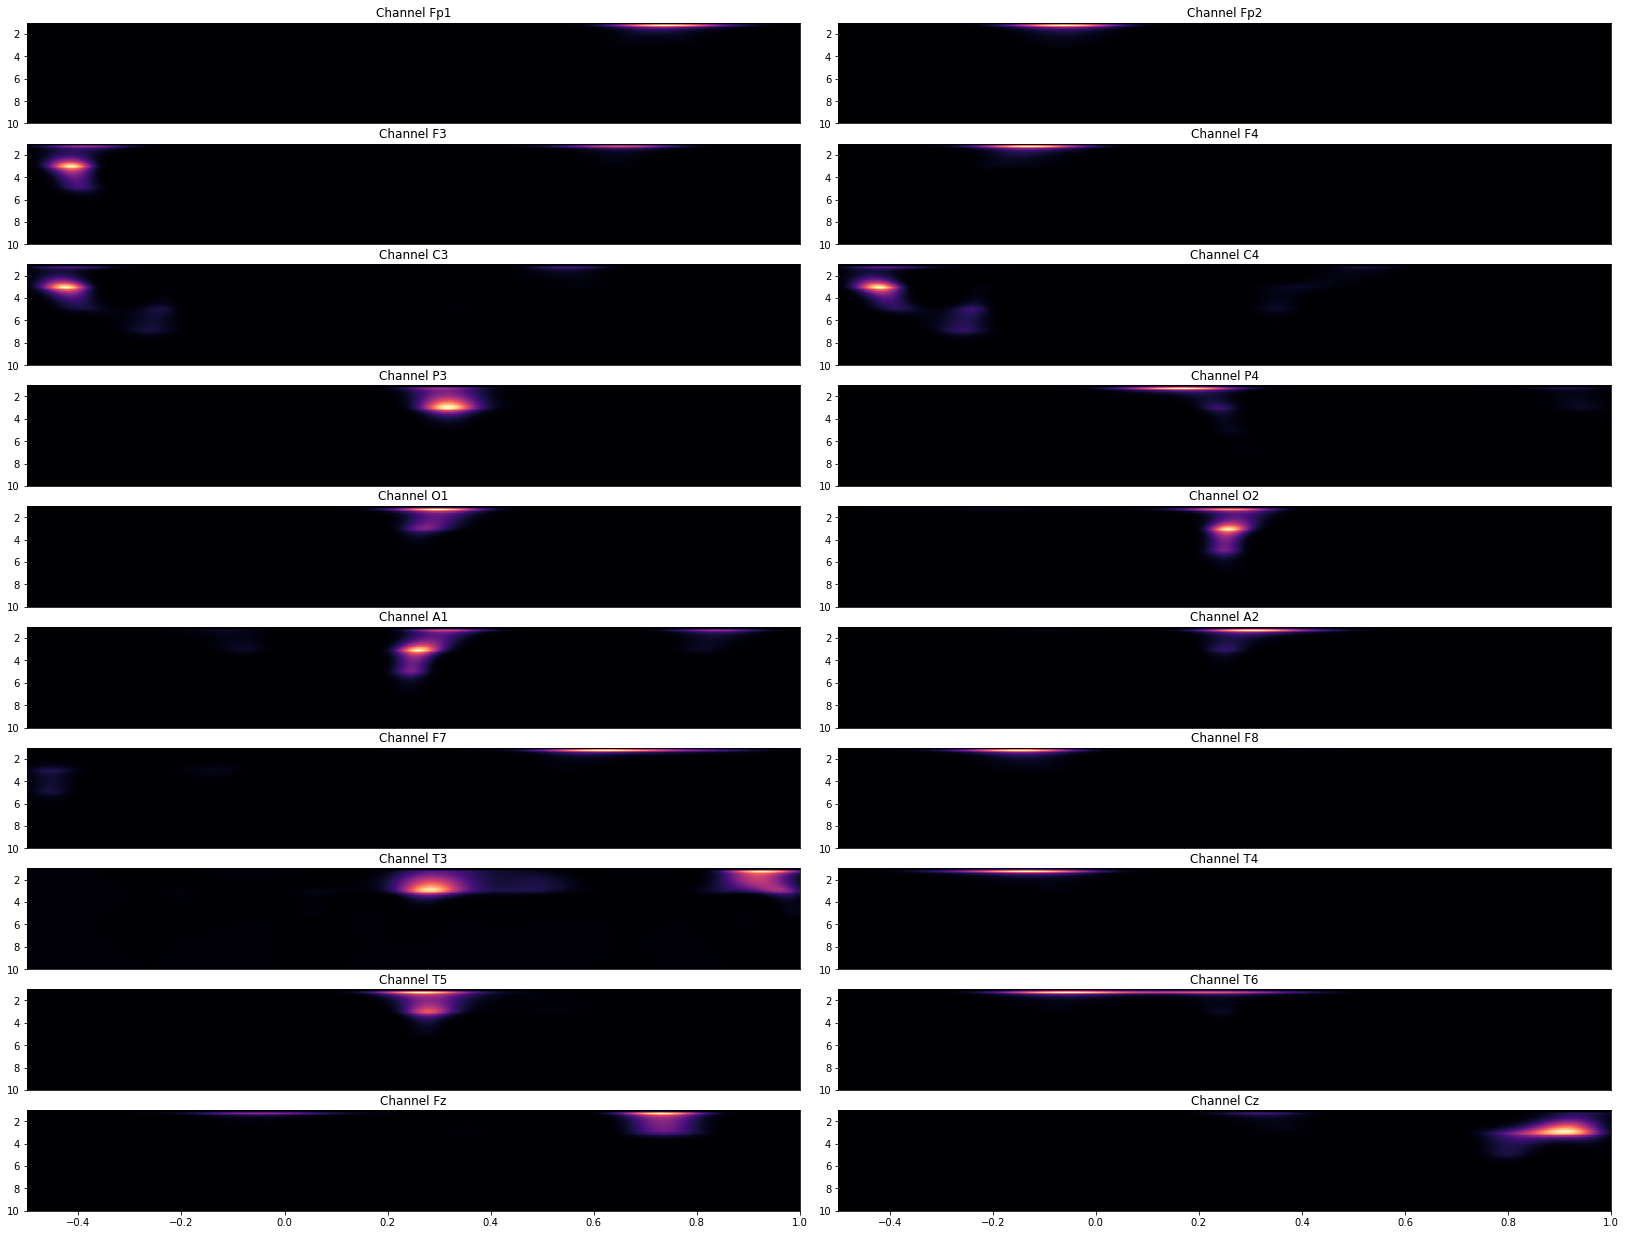

In [45]:
print('State3')
plot_specto(10, 2, size, 300, image_state3[:,:,:20],t0=t0,t1=t1,ff=ff,fi=fi,cm='magma')

In [46]:
X_pipe_2.shape

(13606, 300, 21)

In [47]:
X_pipe.shape

(13606, 21, 300)

In [62]:
sample = np.random.choice(len(X_pipe), size=int(len(X_pipe)/1))

In [63]:
n_data = len(sample)
split_ratio = 0.2
test_ratio = int(split_ratio*n_data)
train_ratio = int((1.0-split_ratio)*n_data)
y_res = tf.keras.utils.to_categorical(y_pipe-1)

data_ = X_pipe[sample]
data_y_ = y_res[sample]

X_train = data_[0:train_ratio]
X_test  = data_[train_ratio:]
# X_train = np.expand_dims(X_train, axis=3)
# X_test = np.expand_dims(X_test, axis=3)

y_train=data_y_[0:train_ratio]
y_test=data_y_[train_ratio:]

In [64]:
print(f'X train shape: {X_train.shape}')
print(f'y train shape: {y_train.shape}')
print(f'X test shape: {X_test.shape}')
print(f'y test shape: {y_test.shape}')

X train shape: (10884, 21, 300)
y train shape: (10884, 3)
X test shape: (2722, 21, 300)
y test shape: (2722, 3)


In [65]:
def CWT_prep(X,fi=1,ff=10,nc =3,f_int=0.1):
    X_cwt = CWT(X,n_c=nc,f_int=f_int,fi=fi,ff=ff)
    X_cwt = normalizer(X_cwt)
    X_cwt = np.expand_dims(X_cwt, axis=4)
    X_cwt = np.moveaxis(X_cwt,1,3)
    return X_cwt

In [ ]:
X_test_cwt = CWT_prep(X_test)
X_test_cwt.shape

 93%|████████████████████████████████████████████████████████████████████████▏     | 2521/2722 [22:32<01:47,  1.86it/s]

In [53]:
X_train_cwt = CWT_prep(X_train)
X_train_cwt.shape

100%|█████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 587.69it/s]


(10, 90, 300, 21, 1)

In [19]:
X_test[0,:,:,:].shape

(90, 200, 6, 1)

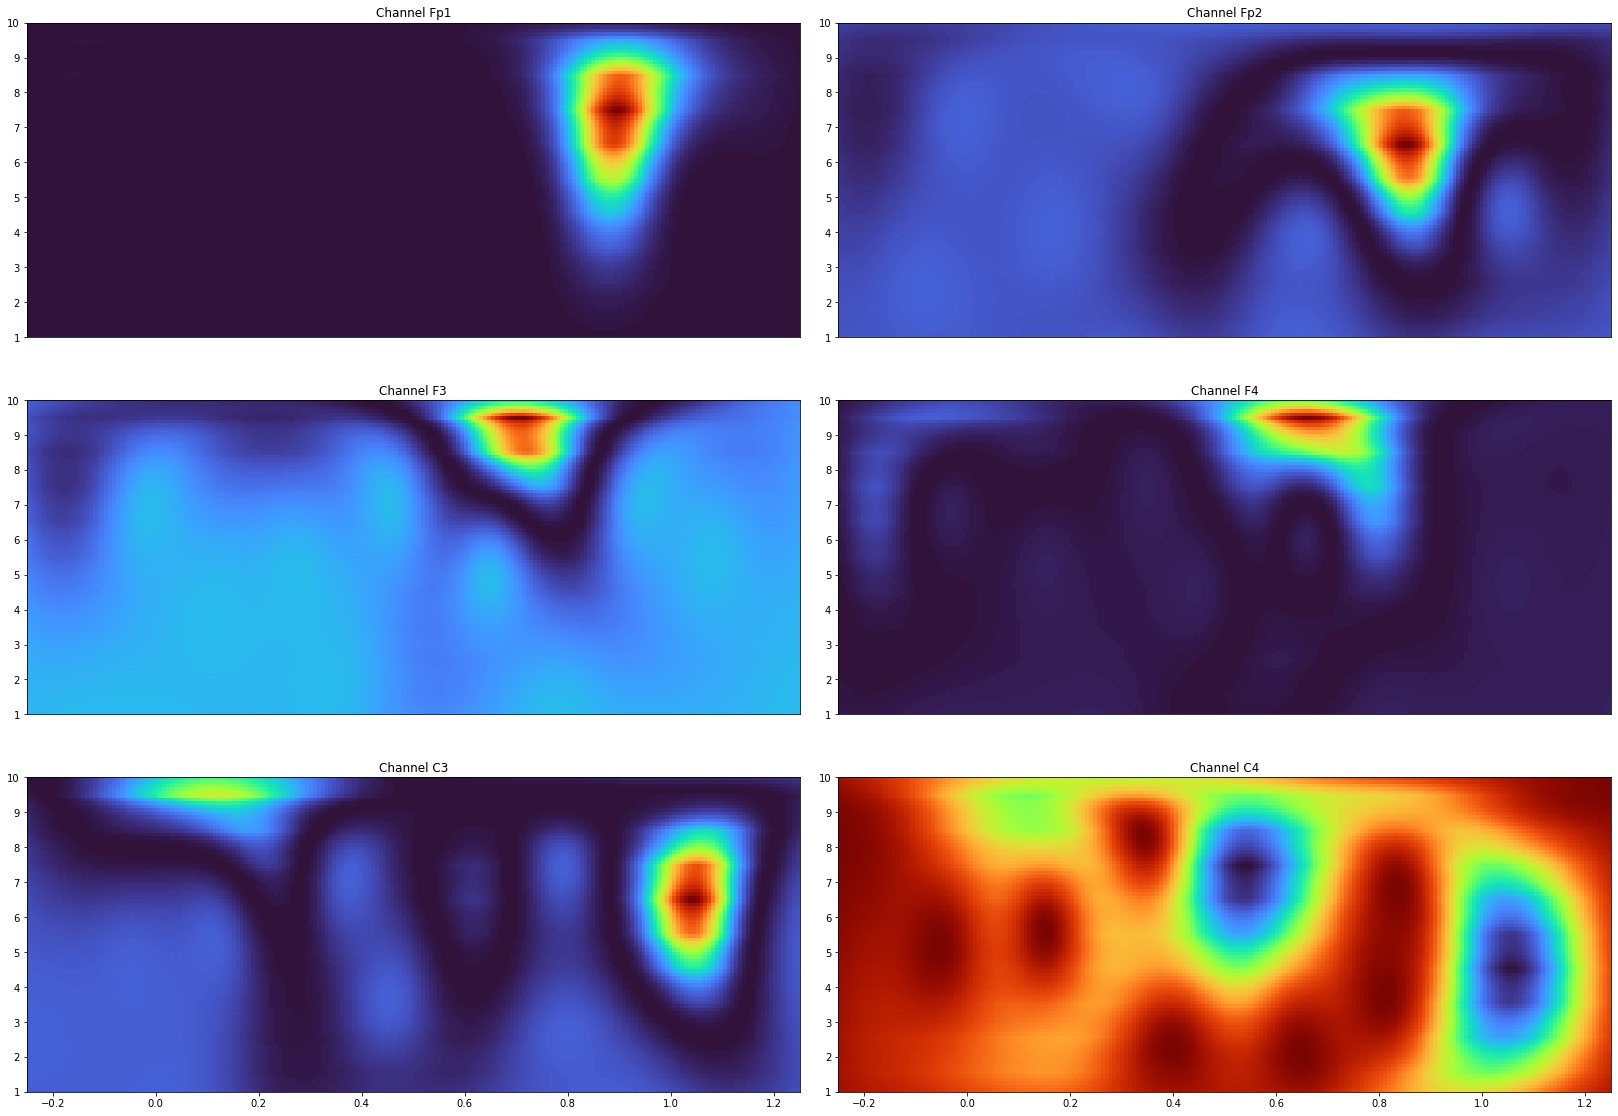

In [93]:
plot_specto(3, 2, 90 ,200, X_train[0,:,:,:],t0=-0.25,t1=1.25,ff=1,fi=10,cm='turbo')

In [24]:
import os

In [64]:
# os.mkdir('CWT-D')
np.save('CWT-D/X_train_s_2',X_train_cwt)
np.save('CWT-D/X_test_s_2',X_test_cwt)
np.save('CWT-D/y_train_s_2',y_train)
np.save('CWT-D/y_test_s_2',y_test)

In [82]:
def nan_manager(X,y):
    sequence = []
    for i in tqdm(range(X.shape[0])):
        if np.isnan(X[i,:,:,:]).any() :
            sequence.append(False)
        else:
            sequence.append(True)
    X_del = X[sequence]
    y_del = y[sequence]
    print(f'After the cleaning {len(X)-len(X_del)} rows were dropped')
    return X_del,y_del

In [85]:
np.isnan(X_train).any()

False

In [84]:
X_train,y_train = nan_manager(X_train,y_train)

100%|███████████████████████████████████████████████████████████████████████████| 3616/3616 [00:00<00:00, 42497.53it/s]


After the cleaning 226 rows were dropped


In [86]:
X_test,y_test = nan_manager(X_test,y_test)

100%|██████████████████████████████████████████████████████████████████████████████| 896/896 [00:00<00:00, 5085.06it/s]


After the cleaning 56 rows were dropped


In [51]:
X_test.shape

(787, 90, 200, 6, 1)

In [91]:
np.isnan(X_test).any()

False

In [92]:
np.isnan(X_train).any()

False

In [66]:
index = []
for i in tqdm(range(X_train.shape[0])):
    if np.isnan(X_train[i,:,:,:]).any() :
        index.append(i)

100%|███████████████████████████████████████████████████████████████████████████| 3390/3390 [00:00<00:00, 43139.36it/s]


In [68]:
len(index)

113

In [69]:
X_train[index[0]]

array([[[[        nan],
         [-0.08279704],
         [-0.05509963],
         [ 0.5304397 ],
         [-0.09629055],
         [ 1.9276725 ]],

        [[        nan],
         [-0.08200644],
         [-0.05509128],
         [ 0.5657711 ],
         [-0.09430929],
         [ 2.0315802 ]],

        [[        nan],
         [-0.08123135],
         [-0.05508398],
         [ 0.6014995 ],
         [-0.09232803],
         [ 2.1386366 ]],

        ...,

        [[        nan],
         [-0.0986245 ],
         [-0.05555908],
         [-0.09044024],
         [-0.13962112],
         [-0.11341109]],

        [[        nan],
         [-0.09865163],
         [-0.05556639],
         [-0.10096026],
         [-0.13971399],
         [-0.1167812 ]],

        [[        nan],
         [-0.09869038],
         [-0.05557311],
         [-0.11078557],
         [-0.13979912],
         [-0.11983152]]],


       [[[        nan],
         [-0.08071978],
         [-0.05503543],
         [ 0.5276608 ],
         [-0